<a href="https://colab.research.google.com/github/Bouncy0Knight/5final/blob/main/CompModNervSys_exercise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
# Exercise 5: Simulating leaky integrate and fire neuron model in NEURON

### Exercise goals

1) Become familiar with basic functions of NEURON simulator package

2) Simulate leaky integrate and fire neuron model in NEURON by adding spiking mechanism to RC neuron model

3) Generate and understand frequency–input plot of neuronal excitability

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with ***Q:*** preceding them, write your responses in text cells. 


In [1]:
!git clone https://github.com/CompModNervSystem/CompModNervSys-LIFneuron.git # downloads repository into our Google colab session's file system



Cloning into 'CompModNervSys-LIFneuron'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), 49.62 KiB | 438.00 KiB/s, done.


Since NEURON is an external toolbox (doesn't come prepackaged in Google colab), we'll need to install it at the start of a new session. There are a couple different ways to install python packages, but the easiest is to use the built in package installer `pip`. Normally, this would be done outside of the python environment in a command-line shell environemnt (e.g., from the `Terminal` app on mac/linux or one of the various shell environments on windows). But, we can also do this from within a Jupyter/Colab notebook using the the % sign (aka [magics](https://ipython.readthedocs.io/en/stable/interactive/magics.html)).

Run the cell below to install NEURON

In [2]:
%pip install neuron # only need to run this cell once to install 
                    # neuron in the local jupyter environment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 15.9 MB/s eta 0:00:00


We also need to compile a file used by NEURON to compute user-created membrane mechanisms more efficiently, called a [mod file](https://www.neuron.yale.edu/phpBB/viewtopic.php?t=3263). We'll use it for the final part of the exercise, but we need to compile it here before importing neuron. 

**Make sure to run this cell before importing neuron in the cell's below, otherwise the mechanism won't be loaded into our environment and we'll get errors later on.**

In [3]:
!nrnivmodl CompModNervSys-LIFneuron/mechanisms # compiles additional membrane mechanism file (mod file) for LIF neuron

/content
Mod files: "CompModNervSys-LIFneuron/mechanisms/CompModNervSys-LIFneuron/mechanisms/spikeout.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../CompModNervSys-LIFneuron/mechanisms/spikeout.mod
Translating spikeout.mod into /content/x86_64/spikeout.c
Thread Safe
 -> Compiling spikeout.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


# Recapping basics of scripting in NEURON

Below, we'll review the basic steps shown in the NEURON Python tutorial (Adapted from https://neuron.yale.edu/neuron/docs/scripting-neuron-basics)

In [4]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary 
import matplotlib.pyplot as plt
import numpy as np



## Step 1: Create a cell

In [5]:
# Create a single section we'll call 'soma'
soma = h.Section(name='soma') 

When we start to build neuron models with more than one section, a useful function is `h.topology()`, which displays the topological (tree-like) structure of all the sections we created in the model. This tells you how the *sections* are connected to each other and how many *segments* each section has. For our single section model, it's fairly simple, but you can use it to see what you've created so far.  

In [6]:
h.topology()


|-|       soma(0-1)



1.0

A useful `method` (a function that can be called on an object) that exists for each NEURON section is the `psection` method. It returns a Python dictionary displaying the properties of a section.

In [7]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x2bdeda0',
 'cell': None}

If you wanted to access, for example, the length of this section, you could use the `'morphology'` key and grab the value of `L`:

In [8]:
print('L = {}'.format(soma.psection()['morphology']['L']))

L = 100.0


<span style="color:red"> <b><i>Q2</b></i>: By inspecting the output of psection, what are the default values NEURON assigned to length, diameter, and cm? The default units for all these quantities can be found <a href="https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html ">here</a> </span>

It's usually more efficient to grab some of these values directly, e.g., you can access a section and set it's value directly using dot notation:

In [9]:
soma.L

100.0

## Step 2: Set the cell's morphological (geometrical) properties

Set the soma's diameter (`diam`) and length (`L`) to $20 \mu m$. Use `psection` to check that the values have been updated. 

In [10]:
# Your code goes here
soma.diam = 20
soma.L = 20
soma.psection()

We'll also specify that this section has a single segment using `nseg`

In [11]:
soma.nseg = 1

You can also probe objects with Python's built in `dir()` function, e.g. for the soma:

In [12]:
dir(soma)

['L',
 'Ra',
 '__call__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allseg',
 'arc3d',
 'cell',
 'children',
 'connect',
 'diam3d',
 'disconnect',
 'has_membrane',
 'hname',
 'hoc_internal_name',
 'insert',
 'is_pysec',
 'n3d',
 'name',
 'nseg',
 'orientation',
 'parentseg',
 'psection',
 'pt3dadd',
 'pt3dchange',
 'pt3dclear',
 'pt3dinsert',
 'pt3dremove',
 'pt3dstyle',
 'push',
 'rallbranch',
 'same',
 'spine3d',
 'subtree',
 'trueparentseg',
 'uninsert',
 'wholetree',
 'x3d',
 'y3d',
 'z3d']

You can also do this to see all the functions, variables, etc. available in NEURON's `h` submodule, which allows us to access NEURON's `hoc` interpreter (basically like the backend). We'll use `textwrap` as in the NEURON Python tutorial to make the display a little cleaner

In [13]:
import textwrap
print(textwrap.fill(', '.join(dir(h))))

APCount, AlphaSynapse, AtolTool, AtolToolItem, Avogadro_constant,
BBSaveState, CVode, DEG, Deck, E, ExecCommand, Exp2Syn, ExpSyn,
FARADAY, FInitializeHandler, Family, File, GAMMA, GUIMath, Glyph,
Graph, HBox, IClamp, Impedance, Inserter, IntFire1, IntFire2,
IntFire4, KSChan, KSGate, KSState, KSTrans, L, LinearMechanism, List,
Matrix, MechanismStandard, MechanismType, MenuExplore, NEURONMainMenu,
NetCon, NetStim, NumericalMethodPanel, OClamp, PHI, PI, PPShape,
PWManager, ParallelContext, PatternStim, Plot, PlotShape,
PointBrowser, PointProcessLocator, PointProcessManager,
PointProcessMark, Pointer, PtrVector, PythonObject, R, Ra, Random,
RangeVarPlot, SEClamp, SaveState, Section, SectionBrowser,
SectionList, SectionRef, Shape, ShapeBrowser, ShapeLocation,
SingleChan, SpikeOut, StateTransitionEvent, String, StringFunctions,
SymChooser, TQueue, TextEditor, Timer, VBox, VClamp, ValueFieldEditor,
Vector, WindowGroup, WindowGroupItem, WindowGroupManager, WindowMenu,
__abs__, __add__, __bool_

From the tutorial: "(The <tt>', '.join(...)</tt> tells Python to build a string out of the list returned by <tt>dir</tt> where the items are separated from each other with a comma and a space. The <tt>textwrap.fill(...)</tt> tells Python to split long lines into multiple lines, by default a maximum of 70 characters long.)"

Getting help:

You can also get help from the documentation (docstrings) using the `help()` function or prefacing the method/function with a question mark:

In [14]:
help(soma.insert)

Help on built-in function insert:

insert(...) method of nrn.Section instance
    section.insert(densityMechanismName) e.g. soma.insert('hh')



## Step 3: Add membrane mechanisms

Right now our section just a membrane capacitance with no resistance/conductance, so it looks like the circuit below

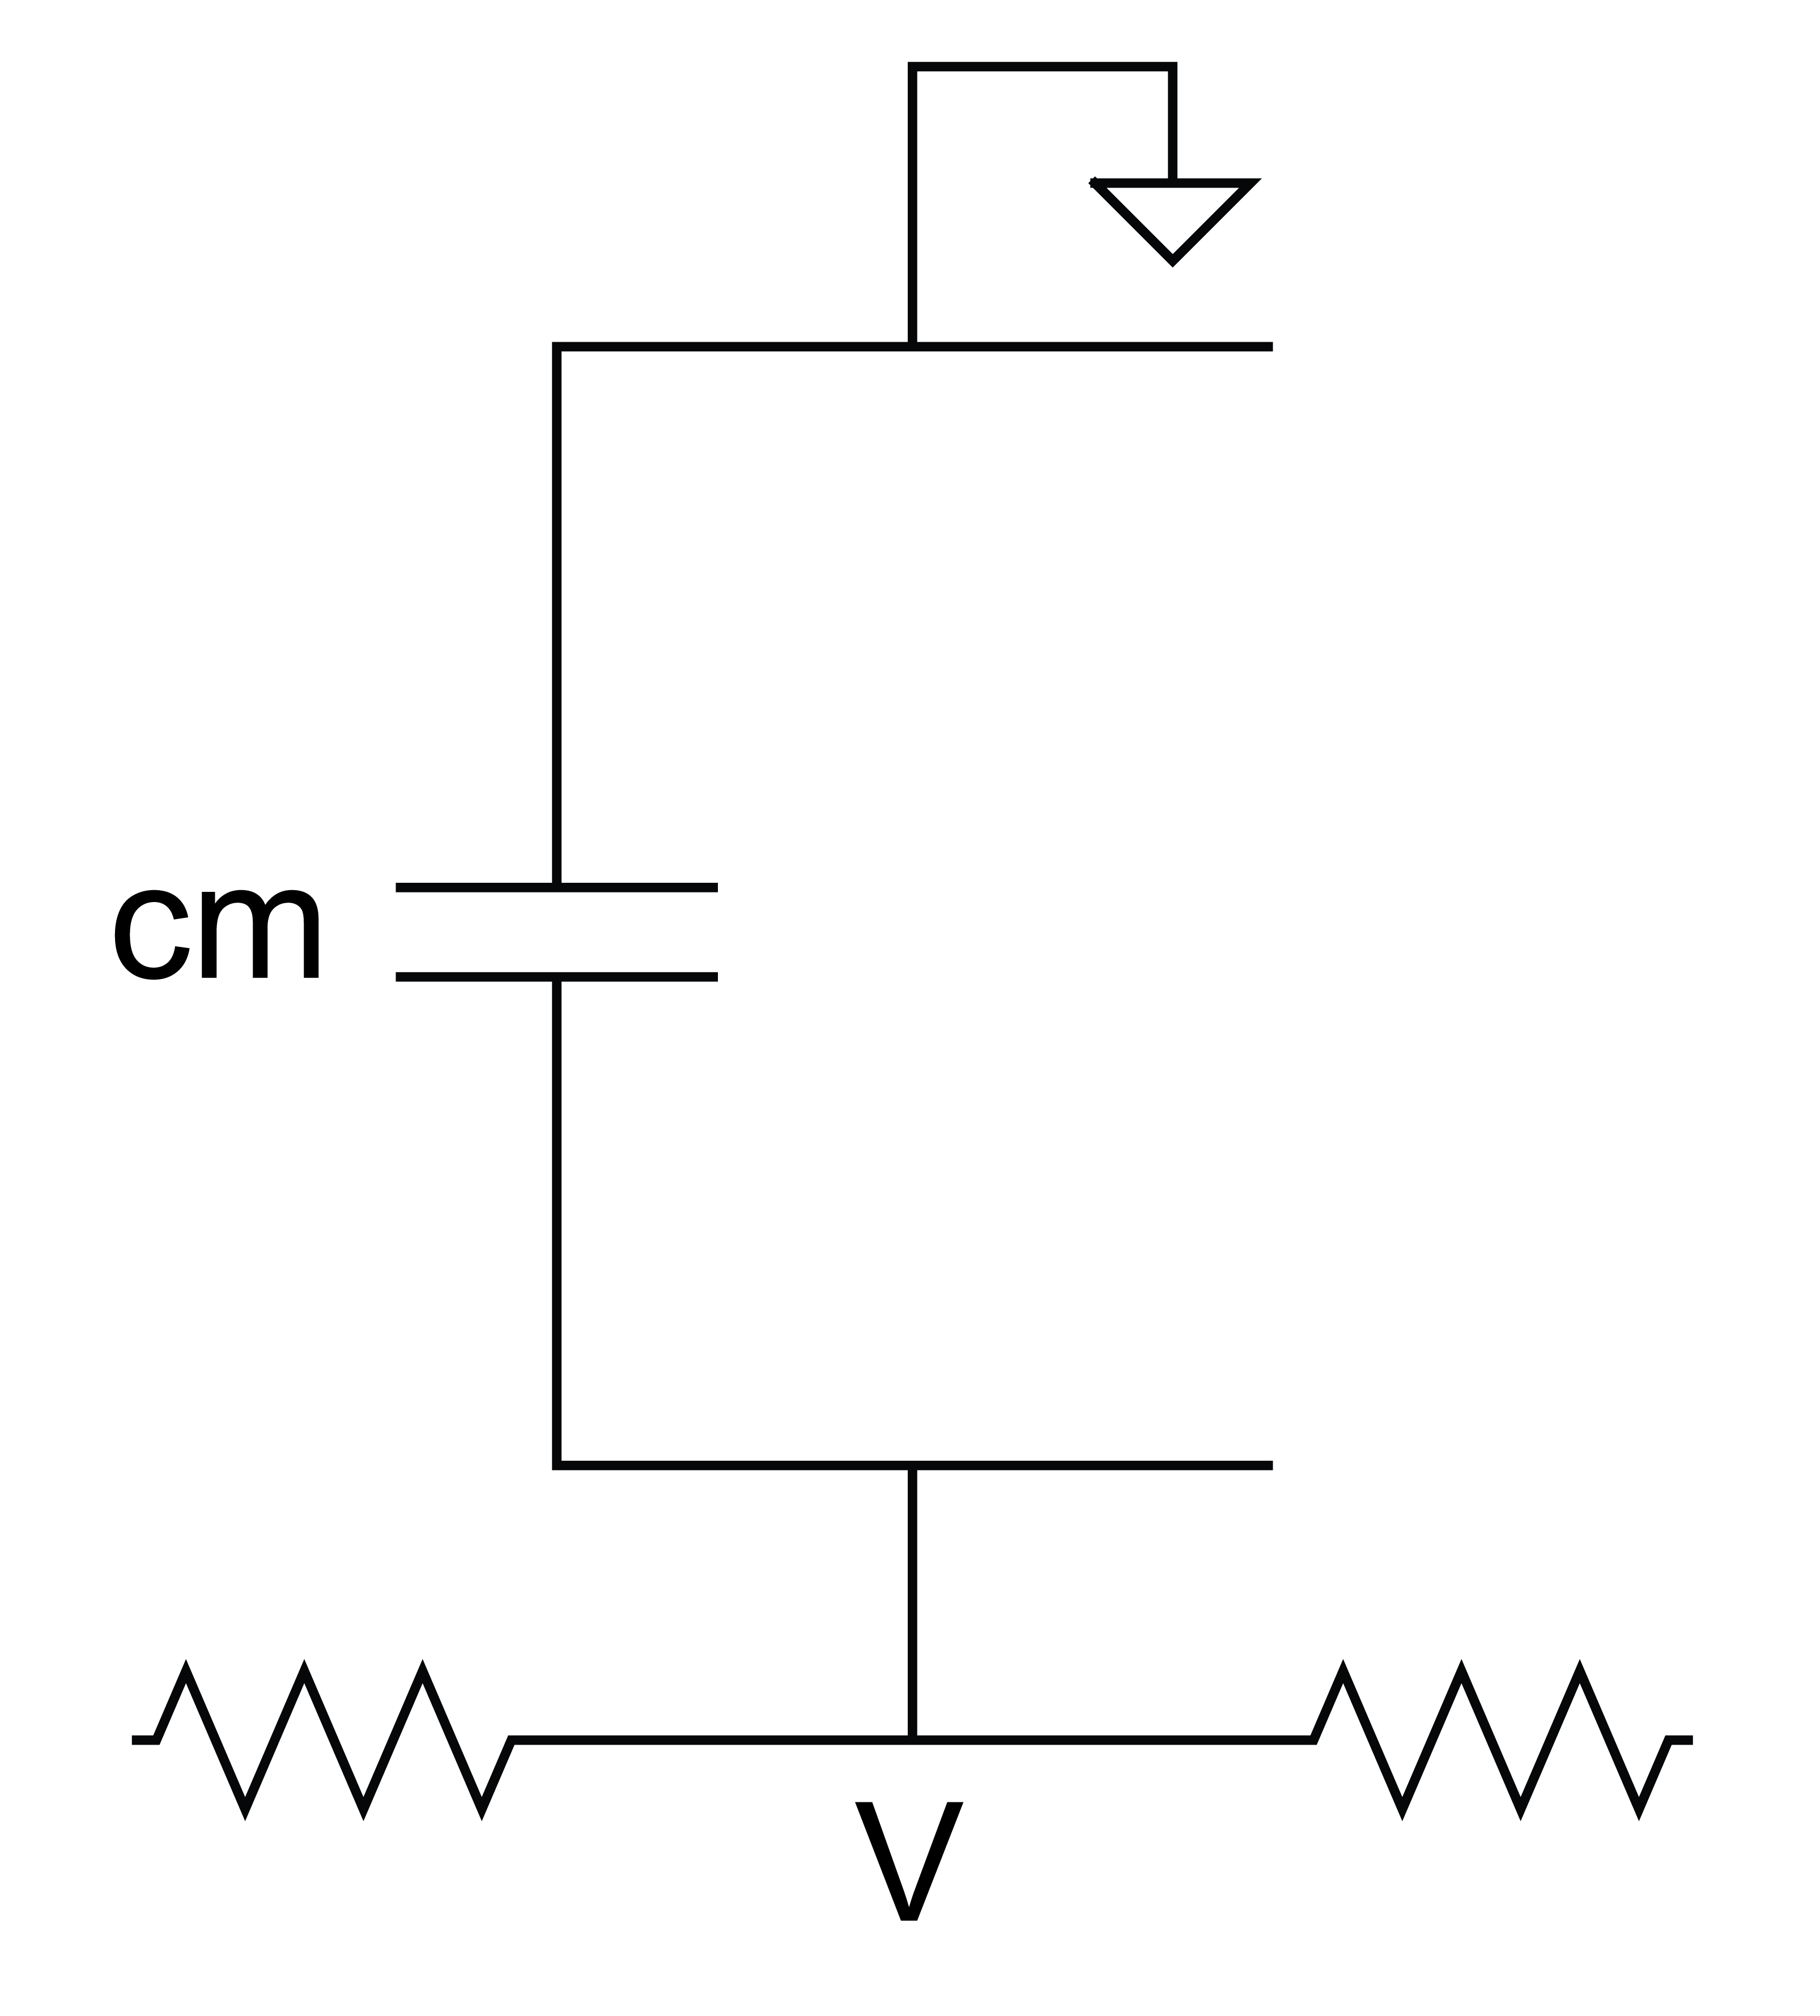

In [15]:
from IPython.display import Image

Image('CompModNervSys-LIFneuron/resources/NEURON_circuit_cm.png',width=250)

To start adding *parallel* membrane conductances, we can use a section's `insert` method. We use this to insert *density* mechanisms, which are membrane mechanisms that allow us to distribute a conductance across a section and specify it's density in terms of conductance per unit area (or current per unit area). 

There are a few built in density mechanisms listed in the [scripting NEURON basics tutorial](https://neuron.yale.edu/neuron/docs/scripting-neuron-basics), shown again below here:

<table border="1" class="docutils">
<colgroup>
<col width="26%" />
<col width="74%"  />
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td><tt>pas</tt></td>
<td>Passive (“leak”) channel.</td>
</tr>
<tr class="row-even"><td><tt>extracellular</tt></td>
<td>For simulating effects of nonzero extracellular
potential, as may happen with leaky patch clamps,
or detailed propertes of the myelin sheath.</td>
</tr>
<tr class="row-odd"><td><tt>hh</tt></td>
<td>Hodgkin-Huxley sodium, potassium, and leakage channels.</td>
</tr>
</tbody>
</table>

Thousands of additional mechanisms are available as part of published model codes on <a href="http://modeldb.yale.edu">ModelDB</a>. 

Eventually we'll use these to model voltage-gated ion channel conductances, but for now we'll start with just a passive "leak" channel, giving us our leaky integrator from last class. The passive channel mechanism is called `pas`:

In [16]:
soma.insert('pas')

soma

Using `psection` we can see what parameters this mechanism has. You'll see it's in the `'density_mechs'` dictionary for density mechanisms under `pas`

In [17]:
soma.psection()

soma.psection()['density_mechs']['pas']


{'g': [0.001], 'e': [-70.0], 'i': [0.0]}

You can see there are three parameters (keys in the dictionary): `g`, `e`, and `i`. The two parameters we can actually set are `g` and `e`, which are the conductance `g` (in $S/cm^2$) and reversal potential `e` (in $mV$) of this leak channel. `i` is just a variable displaying the current at this moment through this density mechanism, so we can't set it, but we could use it to record the current through this conductance if we wanted. 

But first...a note about assigning variables to a section: 

NEURON treats each section as a cable, meaning it allows axial current flow along the cable and through the membrane. Sections are divied into equal size *segments* by setting the `nseg` parameter. You can then access variables like the voltage or passive conductance at any point along your section using the normalized position `x` along the section, which varies from 0 to 1. Remember, this is a numerical model so the values are only actually being solved for at the segment locations, but NEURON linearly interpolates values like voltage between the segment centers within each section. In general, `nseg` should be an odd number, which means accessing (0.5) always gives the value at the middle of the section.

We haven't discussed cable theory yet, so for now we'll stick to a single compartment model by setting `nseg=1`, which means the axial current flow can be ignored and the model behaves like a point neuron. 

To summarize, we access sections by their name and segments by some location on the section.

* Section: ``section``
* Segment: ``section(loc)``

Using the Python `type` function can tell us what a variable is:

In [18]:
print("type(soma) = {}".format(type(soma)))
print("type(soma(0.5)) = {}".format(type(soma(0.5))))

type(soma) = <class 'nrn.Section'>
type(soma(0.5)) = <class 'nrn.Segment'>


Segment variables follow the idiom:

    section(loc).var

And for mechanisms on the segment:

    section(loc).mech.var

or

    section(loc).var_mech

The first form is preferred.

Okay now that we got through all that, use the passive leak channel to model a neuron with a specific membrane resistance $R_{m} = 33 k \Omega/cm^{2}$, reversal potential $E_{rev}=-65 mV$ and specific membrane capacitance $c_{m} = 1 \mu F/cm^{2}$. Remember the relationshib between *resistance* and *conductance*. And if you want to use the last idiom (`var_mech`), the mechanism in this case is `pas`.

In [29]:
# Your code goes here
soma.cm = 1
soma(0.5).pas.g = 1/33000
soma(0.5).pas.e = -65


Another useful variable we can now access is the `area` parameter, which tells us the surface area of a segment within our section. We already set the length `L` and diameter `diam` above, so now let's see what surface area that gave us. NEURON outputs the area in $\mu m^{2}$

In [30]:
soma(0.5).area()

157079.63267948964

## Step 4: Insert a stimulus

We can add a current injection (also known as a current *clamp* because it clamps the current to the value we decide. This is done with the `IClamp` object, which is a `hoc` object, so we have to access through the `h` submodule. `IClamp` just requires us to specify the *segment* in which we want to insert it. This is a type of *Point Process*, which are just point sources of current. To insert it to the middle segment (our only segment in this case) of the soma, we use:

In [31]:
iclamp = h.IClamp(soma(0.5))

Below we'll use `dir` to look at the methods and parameters built into `IClamp`

In [32]:
print([item for item in dir(iclamp) if not item.startswith('__')])

['amp', 'baseattr', 'delay', 'dur', 'get_loc', 'get_segment', 'has_loc', 'hname', 'hocobjptr', 'i', 'loc', 'same']


The three main properties we'll want to set should be familiar from last exercise: 

`amp` - the amplitude in $nA$

`delay` - the time the current stimulus turns in $ms$

`dur` - the duration the current stimulus is held at `amp` (stays on) in $ms$

Below, set the delay to $5 \; ms$, the duration to $20 \; ms$, and the amplitude to $50 \; pA$

In [33]:
iclamp.delay = 5
iclamp.dur = 20
iclamp.amp = 0.05

Another useful method is the `get_segment()` method, which outputs the segment the current clamp is inserted to. Try using it below:

In [34]:
iclamp.get_segment()

soma(0.5)

Now when we use `psection` we can see the `IClamp` has been added to the model in the `point_processes` dictionary. Use it below to check

In [35]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0], IClamp[1]}},
 'density_mechs': {'pas': {'g': [3.0303030303030302e-05],
   'e': [-65.0],
   'i': [0.0]}},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x2bdeda0',
 'cell': None}

## Step 5: Add recording variables

Now we could run a simulation but we wouldn't be able to see our output unless we were using NEURON's GUI to visualize the results. Even then, we wouldn't be able to use our simulation results to do any analysis. We can record variables during a simulation using NEURON's `Vector` class (`h.Vector`), which has a useful method called `record`. This class can be tricky to use. To specify a variable to record, we actually have to prefix it's name with `_ref_`. So to record the membrane potential at the soma `soma(0.5).v` and corresponding time points, which is always stored in a hoc variable `h.t` we use:

In [36]:
v = h.Vector() # create an empty vector to store voltage (mV)
t = h.Vector() # create an empty vector to store time (ms)
v.record(soma(0.5)._ref_v)
t.record(h._ref_t)

Vector[6]

Try writing similar code to record the current delivered by our `IClamp`, which we saved to the python variable `iclamp`, below and save it in a vectort called `i_stim`.

In [37]:
# Your code goes here
i_stim = h.Vector()
i_stim.record(iclamp._ref_i)

Vector[7]

## Step 6: Run the simulation

Now we're almost ready to run. We just need to specify our initialization condition (initial voltage), simulation time step, and duration. By default, NEURON will integrate the differential equation describing our system using a different form of the Euler method we discussed called *Backward euler*, which is a more stable and accurate version. There are more advanced integration methods available (Crank-nicholson and variable time step methods), but this should be sufficient for our purposes. 

Let's use an initial voltage, set by `h.v_init` to our reversal potential, simulation duration, set by `h.tstop` to $20\; ms$, and time step, step by `h.dt` to $0.1\; ms$.  

In [38]:
# Set simulation parameters
h.v_init = soma(0.5).pas.e # Your code goes here
h.tstop = 60 # Your code goes here
h.dt = .1 # Your code goes here

Okay, now we're finally ready to go. To run the simulation, we can use the `h.run()` NEURON function. The code cell below both runs the model and plots it using `matplotlib`, wrapped in a function called `run_and_plot_sim()`

Changed dt


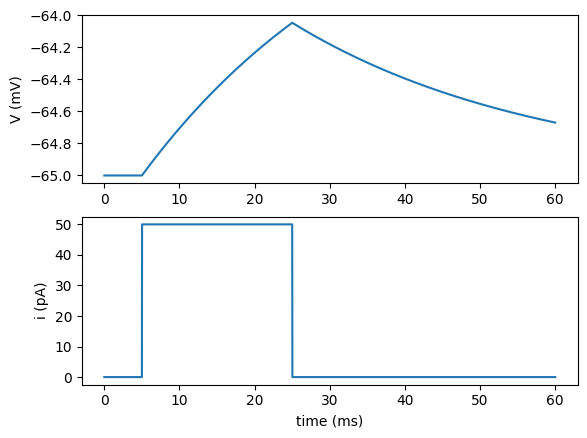

In [39]:
def run_and_plot_sim(t,v,i_stim):
    h.run()
       
    # Plot results
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(t,v)
    ax.set_ylabel('V (mV)')
    ax = fig.add_subplot(212)
    ax.plot(t,i_stim*1e3)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('i (pA)')

run_and_plot_sim(t,v,i_stim)

What happens if we set the passive conductance extremely low (effectively turning it off)? Try it and run/plot below with `run_and_plot_sim()`.

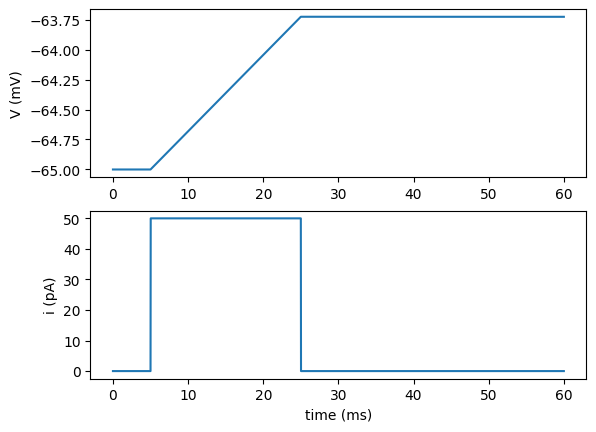

In [41]:
soma(0.5).g_pas = 1e-8

run_and_plot_sim(t,v,i_stim)

<span style="color:red"> 
<b><i>Q2:</b></i> Describe what changed about the voltage dynamics and why, in terms of the model's electrical properties
</span>

# Simulating the Leaky integrate and fire model in Python

So far, we've simulated the *passive* properties of neurons. But as we know, as soon as the membrane potential reaches a critical value, known as the *threshold*, neurons fire action potentials (or "spikes"). Next class, we'll start introducing the detailed model of the squid axon developed by Alan Hodgkin and Alduous Huxley in 1952, which has mostly held up for over 70 years. In the most basic terms, action potentials consist of a neuron's membrane voltage increasing due to inputs (whether from current injection or synapses), reaching a threshold, rapidly going to a high depolarized value, then returning back to the rest potential and being unable to fire for some period of time, termed the refractory period. 

People have modeled this "phenomenologically" for decades using the leaky integrate and fire neuron model, which simply adds a nonlinearity to this otherwise linear model. Whenever the votlage reaches a threshold (we define), we basically say the cell "fired", reset its potential to rest, and hold it there until the refractory period is over. Spikes are treated as an instantaneous event that's not actually captured by the voltage dynamics of the model. We could artificially force the voltage to a value of our choosing (say +40 mV), but typically people are more interested in the spike *timing* when using these models. 

The model the membrane is the same, we just add the rule described above to the integration scheme

$\frac{dV_{m}(t)}{dt} =  I(t)/C_{m} - \frac{V_{m}(t) - V_{r}}{R_{m}C_{m}}$


Since NEURON is made for biophysical neuron modeling, modeling the LIF neuron model is a little tricky. There's a built in model of integrate and fire neurons in NEURON ([here](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IntFire4)), but the voltage at each point in time is hard to extract since takes advantage of the analytical solution for this model's voltage to speed up simulation and "skip" time points between action potentials. 

So below, I've included a version of this model I wrote in python. After that, I've included a version in NEURON that does the same thing, but  takes advantage of some more advanced functions that we won't cover just yet. 

In [42]:
def simLIFneuron(dt,tstop,V0,Rm,Cm,Vr,I,Vth,Vreset,refrac_per=2,AP_peak=40):
    # dt - time step (ms)
    # tstop - simulation duration/last time point (ms)
    # V0 - initial membrane voltage (mV)
    # Rm - membrane resistance (MOhm)
    # Cm - membrane capacitance (nF)
    # Vr - rest potential (mV)
    # I - arbitrary current vector (nA)
    # Vth - Threshold for AP firing (mV)
    # refrac_per - refractory period (ms)
    # AP_peak - peak AP value to set Vm after crossing threshold
    t = np.arange(0,tstop+dt,dt) # time vector (ms)    
    spike_times = []
    Vm = np.zeros(t.shape)
    Vm[0] = V0
    for i in range(0,len(t)-1):        
        dVm_dt = I[i]/Cm - (Vm[i] - Vr)/(Rm*Cm) # with I/Cm gives V/s (same as mV/ms) with I in nA, Cm in nF
                                                     # Rm*Cm gives ms with Rm in MOhm and Cm in nF (1e6*1e-9 = 1e-3 sec)                                                             
        if len(spike_times) > 0 and t[i+1] - spike_times[-1] < refrac_per:
            Vm[i+1] = Vreset # Fix Vm at Vreset
        else:
            Vm[i+1] = dt*dVm_dt + Vm[i] # normal evolution of Vm
        
        if Vm[i+1] > Vth: # Vm crosses threshold for firing 
            Vm[i+1] = Vreset # set Vm to AP peak to simulate a spike in single time step
            spike_times.append(t[i+1])            

    return Vm,t,spike_times

def genCurrentPulse(dt,tstop,I_del,I_dur,I_amp):
    t = np.arange(0,tstop+dt,dt) # time vector (ms)    
    I = np.zeros(t.shape) # A
    I[np.logical_and(t > I_del, t <= I_del + I_dur)] = I_amp
    return I, t

Make a function below to run and plot the output of these "python" simulations

In [43]:
def run_and_plot_LIFpy(dt,tstop,V0,Rm,Cm,Vr,Vth,Vreset,I_del,I_dur,I_amp,refrac_per=2,AP_peak=40):
    
    I, t = genCurrentPulse(dt,tstop,I_del,I_dur,I_amp)
    Vm,t, spike_times = simLIFneuron(dt,tstop,V0,Rm,Cm,Vr,I,Vth,Vreset,refrac_per,AP_peak)


    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(t,Vm)
    ax.set_ylabel('V (mV)')
    ax = fig.add_subplot(212)
    ax.plot(t,I)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('i (pA)')


    return Vm, spike_times, I, t

Now, let's simulate a case of constant current injection into the model we started building earlier in NEURON.

Again, we'll use a specific membrane resistance $R_{m} = 33 k \Omega/cm^{2}$, reversal potential $E_{rev}=-65 mV$ and specific membrane capacitance $c_{m} = 1 \mu F/cm^{2}$. You may notice, the surface area of a cylinder with diameter $diam$ and length $L$ equal to its diameter (which we used in NEURON) is the same as a sphere with the same diameter (which we modeled in previous exercises). This doesn't include the surface area of the caps, which aren't represented in the cable model. So, you can use either case to calculate the surface area for the model and you should get the same surface area as we got earlier. 

Apply a constant $50 \; pA$ current injection starting at $5 \; ms$, this time for $100 \; ms$, and end your simulation at $150 \; ms$. Set the initial voltage to the rest potential. 

For the LIF neuron model, we'll use a threshold of $40 \; mV$, a refractory period of $4 \; ms$, a reset potential of our rest potential, and peak AP of $40 \; ms$ (this latter parameter doesn't matter and is pretty much just for visualization). 

In [ ]:
# Model parameters
# Your code goes here
dt = .5 #ms
tstop = 100 #ms
V0 = -70 #mV
Rm = 33*.001
Cm = 1 * 1000
Vr = -70 #mV WHAT VALUE SHOULD WE USE HERE??
Vth = 40 
I_del = 5
I_dur = 20
I_amp =.05 #nA
refrac_per = 4
Ap_peak = 40
Vreset = Ap_peak #???
# Stimulation parameters


# Simulation parameters
Vm, spike_times, I, t = run_and_plot_LIFpy(dt,tstop,V0,Rm,Cm,Vr,Vth,Vreset,I_del,I_dur,I_amp,refrac_per,Ap_peak)

Vm, spike_times, I, t = run_and_plot_LIFpy()


# Simulating the Leaky integrate and fire model in NEURON

To simulate the LIF neuron with its spiking mechanism in NEURON, we'll use a class I created called `LIFcell`. It includes all the relevant methods to generate the cell and store recordings. We'll use it below to do the same thing, but using the NEURON simulator instead. At the moment, it may not be obvious why we'd want to do this if we already have a Python implementation, but as we'll see, if you want to add new membrane conductances or connect neurons up into networks with synapses, NEURON's functionality will become really powerful. 

In [44]:
import shutil
shutil.copy('CompModNervSys-LIFneuron/LIFcell.py','.') # copy LIF cell to current directory for easier importing

'./LIFcell.py'

In [45]:
from neuron import h # reimport in case run time was interrupted
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary 
h.nrn_load_dll('x86_64') 

from LIFcell import LIFcell

# Create cell
cell = LIFcell(0)
cell._setup_recordings() # reinitalize recordings

h.topology() # check that our new cell exists


|-|       soma(0-1)
|-|       LIF[0].soma(0-1)



1.0

In [ ]:
# Add stimulation
iclamp = h.IClamp(cell.soma(0.5))

# Set amplitude, delay (start time), and duration
iclamp.amp = 0.05 # nA
iclamp.delay = 5 # ms
iclamp.dur = 100 # ms

# Record current clamp again
iclamp_rec = h.Vector()
iclamp_rec.record(iclamp._ref_i)


In [ ]:
def run_and_plot_LIFnrn(cell,i_stim):
    h.run()
    t = cell.t.to_python(np.zeros(len(cell.t)))  # convert to numpy arrays (not actually necessary for plotting)
    v = cell.soma_v.to_python(np.zeros(len(cell.soma_v)))
    spike_times = cell.spike_times.to_python(np.zeros(len(cell.spike_times))) # this one does need to be a numpy array
    i_stim = i_stim.to_python(np.zeros(len(i_stim))) # same here, numpy arrays allows multiplying by scalar but NEURON Vectors don't    
    # Plot results
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(t,v)
    ax.vlines(spike_times,ymin=cell.soma(0.5).e_pas,ymax=40,colors='r')
    ax.set_ylabel('V (mV)')
    ax = fig.add_subplot(212)
    ax.plot(t,i_stim*1e3)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('i (pA)')

    return v, spike_times, i_stim, t



In [ ]:
# Set simulation parameters
h.dt = 0.1 # ms - time step
h.v_init = cell.soma(0.5).e_pas # initial voltage (same as reversal potential)
h.tstop = 150 # ms - simulation duration
# Set the LIF model parameters
h.thresh_SpikeOut = -40	# (mV)
h.refrac_SpikeOut = 4 # (ms)
h.vrefrac_SpikeOut = cell.soma.e_pas # (mV) reset potential
# Run and plot simulation

v, spike_times, i_stim, t = run_and_plot_LIFnrn(cell,iclamp_rec)

The results may not be identical due to the different integration methods, but they should be pretty close. Let's use NEURON to see how varying the strength of stimulation alters the firing frequency. 

Below, in a `for` loop, vary the current amplitude over a reasonable range and measure the average frequency (number of spikes divided by duration of the stimulus). Then, plot the frequency in $Hz$ vs. the current amplitude. This is what's called an *F-I* curve of frequency-input curve. 

In [ ]:
# Your code goes here

Now, try modifying the membrane resistance using `cell.soma(0.5).g_pas` to double and half the current value and overlaying the F-I curves of these three models on the same axes.



In [ ]:
# Your code goes here

<span style="color:red"> 
<b><i>Q3:</b></i> How does changing membrane resistance alter the F-I curve? What might this mean for the neuron's relative excitability in a network, i.e. how easily it can generate action potentials?
</span>